In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickthat

In [3]:
api = pickthat.API()
u = api.users()
list(filter(lambda i: '__' not in i, dir(u[3])))

['biography',
 'education',
 'email',
 'environment',
 'experience',
 'linkedin',
 'location',
 'nickname',
 'profession',
 'user_id']

In [4]:
api = pickthat.API()
p = api.images()
p[1].link

'http://lh3.googleusercontent.com/1bg394j9LNZIZ_oRv6FAyooH4dKwY1ke_mcxfc-Bdr1Q7GBGlc0ED1DqZDN5cOIEBbIpBTCxYTMRycWPgaLtDA'

In [5]:
[q.title for q in p]

['Brain MRI',
 'Bouguer gravity map, Southern Tuscany, Italy',
 'Namibian margin',
 'Mancora seismic',
 'Baby tooth in full grown adult',
 'Cell counting',
 'Sobrarbe',
 '2D marine data  from  Southern shelf of Marmara sea ( ın front of the Imralı Basin) ',
 'Ho ho ho',
 'Alaska seismic',
 "Where's the salt?",
 'Ireland seismic',
 'Brazil seismic',
 'Photomicrograph',
 'Parametric Echosounder Profile ',
 'Nova Scotia seismic',
 'Salter–Harris',
 'Synthetic seismic over a thrust',
 'Seismic Oceanography',
 'Marmousi Synthetic',
 '',
 'Mediterranean Sea Evaporites 2D Seismic',
 'Browse basin',
 'Deuteranope ROYGBIV',
 'Parasound profile']

In [6]:
img = [q for q in p if q.title == "Brazil seismic"][0]

In [7]:
# import requests
# from PIL import Image
# from io import BytesIO
# r = requests.get(i[2].link)
# im = Image.open(BytesIO(r.content))

In [8]:
1000/(512/384)

750.0

512 302


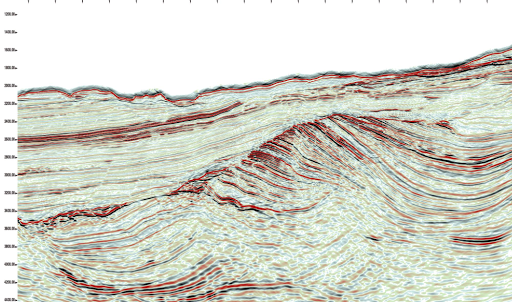

In [9]:
png = img.image()
print (png.width, png.height)
png

In [10]:
picks = api.picks(image_id = img.image_id)
picks[:10]

In [11]:
list(filter(lambda i: '__' not in i, picks[0].__dir__()))

['date', 'ip_addr', 'cohort', 'picks', 'user_id']

In [12]:
xlow, xhigh = 1000, 0
ylow, yhigh = 1000, 0
for i, _ in enumerate(picks):
    pick_array = np.array(picks[0].picks)
    a, b = np.amax(pick_array[:,0]), np.amin(pick_array[:,0])
    c, d = np.amax(pick_array[:,1]), np.amin(pick_array[:,1])
    if a < xlow:
        xlow = a
    if b > xhigh:
        xhigh = b
    if c < ylow:
        ylow = c
    if d > yhigh:
        yhigh = d
    
print('xrange', a, b)
print('yrange', c, d)

xrange 997 37
yrange 425 219


In [13]:
len(picks)  # Should be 429 for Brazil.

429

## Use Shapely and Rasterio to generate heatmap

In [14]:
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString
from rasterio import features

In [49]:
def apply_buffer(row, buffer=1):
    r = np.array(row)
    these_lines = []
    if r.shape[-1] == 2:
        cohort = np.ones((r.shape[0]))
        groups = cohort
    if r.shape[-1] == 3:
        groups = r[:,2]
    for group in np.unique(groups):
        this_line = r[groups==group][:, :2]
        if len(this_line) > 1:
            #these_lines.append(LineString(this_line).buffer(buffer))
            these_lines.append(LineString(this_line))
        else:  # single point, discard
            continue
    #return MultiPolygon(these_lines)
    return MultiLineString(these_lines)

In [50]:
def shapely_heatmap(image_size, picks, weights=None, buffer=5):
    """
    returns a heatmap the same size as the test image
    """
    weights = weights or np.ones((len(picks)))

    shapes = []
    for p, w in zip(picks, weights):
        if len(p.picks) != 0:
            shape = apply_buffer(p.picks, buffer)
            shapes.append((shape, w))  
    heatmap = np.zeros(image_size)
    for i, _ in enumerate(shapes):
        heatmap += features.rasterize(shapes[i:i+1],
                                      out_shape=heatmap.shape,
                                      all_touched=True)
    return heatmap

In [51]:
%timeit shapely_heatmap(np.shape(img.image())[:2], picks, buffer=2)

ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped


1 loops, best of 3: 1.15 s per loop


In [52]:
hm = shapely_heatmap(np.shape(img.image())[:2], picks)

ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped


In [58]:
from scipy.ndimage import filters
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2
from ipywidgets import interact

In [61]:
size = np.shape(img.image())
aspect = size[0]/size[1]
dx = 1000

# Do this in NumPy ...

# pad with zeros for next pow2
k = 5
a = kernel = np.ones((k,k))/(k*k)  # scipy.convolve
b = shapely_heatmap((dx*aspect,dx), picks, buffer=0.1)
A = fft2(a)
B = fft2(b)
np.pad(A)
out = ifft2(A*B)

plt.imshow(out)

/Users/Evan/anaconda/envs/pickthat/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped


ValueError: operands could not be broadcast together with shapes (5,5) (589,1000) 

/Users/Evan/anaconda/envs/pickthat/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped
ERROR:rasterio:Geometry {'coordinates': (), 'type': 'MultiLineString'} at index 0 with value 1 skipped


Time taken to make heatmap: 4.15 seconds.


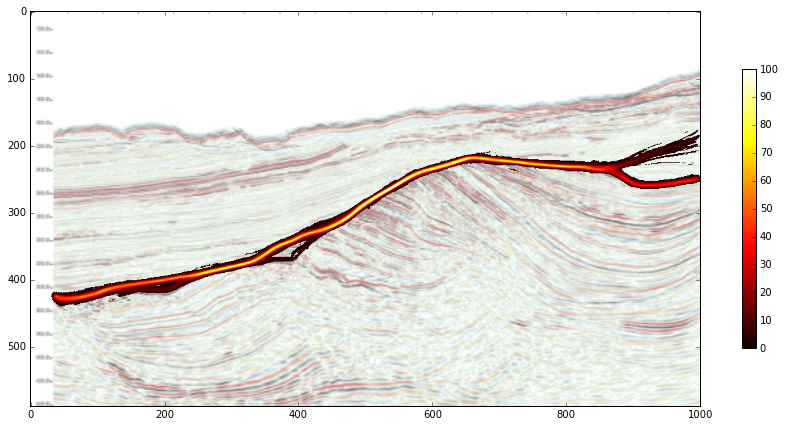

In [55]:
import time
size = np.shape(img.image())
aspect = size[0]/size[1]
dx = 1000
@interact(i=(1,7), j=(0.0,1.0), k=(0.0,1.0))
def draw_heatmap(i=3,j=1.0, k=0.5):
    start = time.time()
    heatmap = shapely_heatmap((dx*aspect,dx), picks, buffer=0.1)
    # heatmap = filters.gaussian_filter(heatmap, i)
    kernel = np.ones((i,i))/(i*i)  # scipy.convolve
    heatmap = fftconvolve(heatmap, kernel, mode='same')  # scipy.convolve.fftconvolve
    heatmap[heatmap <= 3] = np.nan
    plt.figure(figsize=(15,10))
    plt.imshow(img.image(), alpha=k, extent=[0,dx,aspect*dx,0])
    plt.imshow(heatmap, cmap='hot', clim=([0,100]), alpha=j)
    plt.colorbar(shrink=0.5)
    end = time.time()
    elapsed = end - start
    print("Time taken to make heatmap: {:.2f} seconds.".format(elapsed))


## Getting the image

In [ ]:
images.loc[images['image_id']==image_id]

In [ ]:
link = images.loc[images['image_id']==image_id].link[2]
IPImage(url=link)

## Put it all together

In [ ]:
import urllib
from PIL import Image

In [ ]:
# Get the image
link = images.loc[images['image_id']==image_id].link[2]
f = urllib.request.urlopen(link)
img = Image.open(f)

plt.figure(figsize=(12,8))
plt.imshow(img)

for line in these_lines:
    x, y = line.xy
    plt.plot(x, y, color='k', lw=3, alpha=0.75)

plt.show()

In [ ]:
x, y = mls[0].xy
plt.plot(x, y)

In [ ]:
h = images.loc[images['image_id']==image_id].height[2]
w = images.loc[images['image_id']==image_id].width[2]
h, w

## Users

In [ ]:
u = api.users()
u[2].__dict__

## Picks

In [ ]:
image_id = 5910974510923776
api.picks()

In [ ]:
picks.head()